# ACM 650 (Nintendo)
### Volatility Calculation
#### Directly download the data from Yahoo finance to calculate the volatility

[*********************100%***********************]  1 of 1 downloaded
Date
1996-11-19    0.000000
1996-11-20    0.006921
1996-11-21   -0.006921
1996-11-22    0.013793
1996-11-25    0.000000
1996-11-26    0.013606
1996-11-27    0.000000
1996-11-29   -0.020478
1996-12-02   -0.035091
1996-12-03    0.014185
1996-12-04    0.013986
1996-12-05    0.013793
1996-12-06    0.013606
1996-12-09    0.006734
1996-12-10    0.033006
1996-12-11   -0.026318
1996-12-12   -0.013423
1996-12-13   -0.041385
1996-12-16    0.041385
1996-12-17    0.000000
1996-12-18   -0.013606
1996-12-19    0.000000
1996-12-20    0.013606
1996-12-23   -0.041385
1996-12-24    0.041385
1996-12-26   -0.013606
1996-12-27    0.000000
1996-12-30    0.000000
1996-12-31    0.000000
1997-01-02    0.000000
                ...   
2018-10-02   -0.000863
2018-10-03   -0.017862
2018-10-04   -0.028988
2018-10-05    0.021266
2018-10-08   -0.006221
2018-10-09   -0.010530
2018-10-10   -0.028557
2018-10-11   -0.008378
2018-10-12    0.030155
2018-

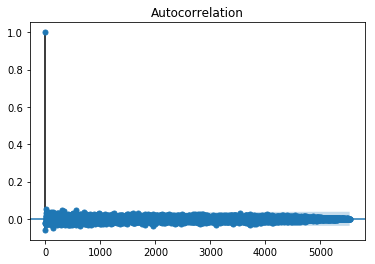

In [33]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
import arch
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
yf.pdr_override()


class stock_vol:

    def __init__(self, tk, start, end):
        self.tk = tk
        self.start = start
        self.end = end
        all_data = pdr.get_data_yahoo(self.tk, start=self.start, end=self.end)
        self.stock_data = pd.DataFrame(all_data['Adj Close'], columns=["Adj Close"])
        self.stock_data["log"] = np.log(self.stock_data)-np.log(self.stock_data.shift(1))

    def mean_sigma(self):
        st = self.stock_data["log"].dropna().ewm(span=252).std()
        sigma = st.iloc[-1]
        return sigma

    def garch_sigma(self):
        model = arch.arch_model(self.stock_data["log"].dropna(), mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = model.fit()
        forecast = model_fit.forecast(horizon=1)
        var = forecast.variance.iloc[-1]
        sigma = float(np.sqrt(var))
        return sigma


if __name__ == "__main__":
    vol = stock_vol("NTDOY", start="1996-11-18", end="2018-11-12")
    test = vol.stock_data["log"].dropna()
    print(test)
    fig = plot_acf(test)
    plt.show()

In [34]:
import math as m
xi=[]
for i in range(0,5533):
    xi.append(test[i])
x1=0
for i in xi:
    x1=x1+i**2
x1/len(xi)
x2=x1/len(xi)
mean=sum(xi)/len(xi)
volatility=m.sqrt(300)*m.sqrt(len(xi)*(x2-mean)/(len(xi)-1))
print('Volatility =', volatility)

Volatility = 0.36187449076675565


### Building stock tree

In [38]:
import sys
import numpy as np
from math import pow
import math
# create the Binomial Tree

def build_stock_tree(S,T,N,sig):
    dt=T/N;
    u=math.exp(sig*math.sqrt(dt));
    d=math.exp(-sig*math.sqrt(dt));
    tree=np.zeros((N+1,N+1))
    for i in range(N+1):
        for j in range(i+1):
            tree[i][j]=S*pow(u,j)*pow(d,i-j)
            
    
    return(tree)

In [39]:
s = [[str(e) for e in row] for row in build_stock_tree(100,0.5,4,0.3873)]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print('\n'.join(table))

100.0            	0.0               	0.0               	0.0               	0.0               
87.20301951764252	114.67492817696348	0.0               	0.0               	0.0               
76.0436661299434 	99.99999999999999 	131.50339152391732	0.0               	0.0               
66.31237301722545	87.2030195176425  	114.67492817696346	150.80141978032327	0.0               
57.82639158482302	76.0436661299434  	99.99999999999999 	131.50339152391732	172.93141982292687


### Building the Cox-Ross-Rubinstein tree

In [42]:
import numpy as np
def CRRTree(type,S0, K, r, sigma,Lsig, T, N,american="false"):
    #we improve the previous tree by checking for early exercise for american options
   
    #calculate delta T    
    deltaT = float(T) / N
 
    # up and down factor will be constant for the tree so we calculate outside the loop
    u = np.exp(sigma * np.sqrt(deltaT))
    d = np.exp(-sigma * np.sqrt(deltaT))
    
    #to work with vector we need to init the arrays using numpy
    fs =  np.asarray([0.0 for i in range(N + 1)])
        
    #we need the stock tree for calculations of expiration values
    fs2 = np.asarray([(S0 * u**j * d**(N - j)) for j in range(N + 1)])
    
    #we vectorize the strikes as well so the expiration check will be faster
    fs3 =np.asarray( [float(K) for i in range(N + 1)])
    
 
   
    a = np.exp(r * deltaT)
    p=((np.exp((r-Lsig)*deltaT))-d)/(u-d);
    oneMinusP = 1.0 - p
 
   
    # Compute the leaves, f_{N, j}
    if type =="C":
        fs[:] = np.maximum(fs2-fs3, 0.0)
    else:
        fs[:] = np.maximum(-fs2+fs3, 0.0)
    
   
    #calculate backward the option prices
    for i in range(N-1, -1, -1):
       fs[:-1]=np.exp(-r * deltaT) * (p * fs[1:] + oneMinusP * fs[:-1])
       fs2[:]=fs2[:]*u
      
       if american=='true':
           #Simply check if the option is worth more alive or dead
           if type =="C":
                fs[:]=np.maximum(fs[:],fs2[:]-fs3[:])
           else:
                fs[:]=np.maximum(fs[:],-fs2[:]+fs3[:])
                
    # print fs
    return fs[0]

In [43]:
for i in range(1,10):
    print(CRRTree('p',100, 90, 0.0221,0.3873,0.0097, 0.5, N=i,american="false"))

7.68586202679695
6.383760934569554
5.977490552599485
6.326331111726902
5.625757594227075
6.219994733262886
5.522422355120405
6.131037298909565
5.713060699751536


In [47]:
for i in range(1,10):
    print(CRRTree('C',100, 90, 0.0221,0.3873,0.0097, 0.5, N=i,american="false"))

18.191061822901947
16.88896073067455
16.482690348704512
16.831530907831876
16.13095739033214
16.72519452936785
16.02762215122547
16.636237095014494
16.21826049585653


### Building the Log normal tree

In [45]:
import numpy as np
def LogNormalTree(type,S0, K, r, sigma,Lsig, T, N,american="false"):
    #we improve the previous tree by checking for early exercise for american options
   
    #calculate delta T    
    deltaT = float(T) / N
 
    # up and down factor will be constant for the tree so we calculate outside the loop
   
    u = np.exp((r-Lsig-(1/2)*sigma*sigma)*deltaT+sigma*np.sqrt(deltaT));
    d = np.exp((r-Lsig-(1/2)*sigma*sigma)*deltaT-sigma*np.sqrt(deltaT));
    
    
    #to work with vector we need to init the arrays using numpy
    fs =  np.asarray([0.0 for i in range(N + 1)])
        
    #we need the stock tree for calculations of expiration values
    fs2 = np.asarray([(S0 * u**j * d**(N - j)) for j in range(N + 1)])
    
    #we vectorize the strikes as well so the expiration check will be faster
    fs3 =np.asarray( [float(K) for i in range(N + 1)])
    
 
   
    a = np.exp(r * deltaT)
    p=((np.exp((r-Lsig)*deltaT))-d)/(u-d);
    oneMinusP = 1.0 - p
 
   
    # Compute the leaves, f_{N, j}
    if type =="C":
        fs[:] = np.maximum(fs2-fs3, 0.0)
    else:
        fs[:] = np.maximum(-fs2+fs3, 0.0)
    
   
    #calculate backward the option prices
    for i in range(N-1, -1, -1):
       fs[:-1]=np.exp(-r * deltaT) * (p * fs[1:] + oneMinusP * fs[:-1])
       fs2[:]=fs2[:]*u
      
       if american=='true':
           #Simply check if the option is worth more alive or dead
           if type =="C":
                fs[:]=np.maximum(fs[:],fs2[:]-fs3[:])
           else:
                fs[:]=np.maximum(fs[:],-fs2[:]+fs3[:])
                
    # print fs
    return fs[0]

In [46]:
for i in range(1,10):
    print(LogNormalTree('p',100, 90, 0.0221,0.3873,0.0097, 0.5, N=i,american="false"))

8.046404022182605
5.977069542881947
6.356717654286955
6.125511484784046
6.0058994697194965
6.119401772682507
5.85596328489441
6.092300119150403
5.772988251315611


In [48]:
for i in range(1,10):
    print(LogNormalTree('C',100, 90, 0.0221,0.3873,0.0097, 0.5, N=i,american="false"))

18.55160381828761
16.48226933898695
16.86191745039198
16.630711280889006
16.511099265824566
16.624601568787483
16.361163080999482
16.597499915255344
16.278188047420624
